- <a href="#Preparation">Preparation</a><br>

- <a href="#EDA">1. EDA</a><br>
 - <a href="#Problem">a. Understand the problem</a><br>
 - <a href="#Univariate">b. Univariate - dependent variable ('is_retained')</a><br>
 - <a href="#Multivariate">c. Multivariate - how the dependent variables and independent variables relate</a><br>
    - <a href="#Numerical">Relationship of the dependent variable and numeric independent variables</a><br>
    - <a href="#Categorical">Relationship of the dependent variable and categorical independent variables</a><br>
    - <a href="#Country">User behaviors</a><br>
    - <a href="#Corr">Correlation matrix</a><br>
    - <a href="#Scatter">Scatter plot between correlated variables</a><br>
     
- <a href="#Retention Rate">2. Retention Rate Analysis and Actionable Insights</a><br>
     - <a href="#Variance">a. Removing features with low variance</a><br>
     - <a href="#Test">b. Univariate feature selection</a><br>
- <a href="https://docs.google.com/presentation/d/1WYa09LWlMSJTeOjViAoPTxvLS31lvyi6ubhFkq-5WGI/edit?usp=sharing">Presentation Slide</a><br>


<p><a name="Preparation"></a></p>
### Preparation

In [1]:
#import package
import numpy as np
import pandas as pd
from scipy import stats, integrate
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import sklearn.feature_selection as fs

In [2]:
import rpy2.ipython
%load_ext rpy2.ipython

In [3]:
#import raw data
act = pd.read_csv('/Users/summer/Downloads/Tumblr_--_Take_home_Assignment/user_act.csv')
regi = pd.read_csv('/Users/summer/Downloads/Tumblr_--_Take_home_Assignment/user_regi.csv')

In [4]:
#convert data to Pandas dataframe
df_act = pd.DataFrame(act)
df_regi = pd.DataFrame(regi)

In [5]:
#check data types

#df_regi.dtypes
#df_act.dtypes

In [6]:
#convert data type

#create hourly column
df_regi['regi_hr'] = pd.to_datetime(df_regi['regi_ts'],unit = 's').dt.hour   
df_act['hr'] = pd.to_datetime(df_act['ts'],unit = 's').dt.hour

#create date column
df_regi['regi_ts'] = pd.to_datetime(df_regi['regi_ts'],unit = 's').dt.date
df_act['ts'] = pd.to_datetime(df_act['ts'],unit = 's').dt.date

#convert user_id to string
df_regi['user_id'] = df_regi['user_id'].astype(str)
df_act['user_id'] = df_act['user_id'].astype(str)

In [7]:
#gather list of users who are active again
lst1 = set(df_act.loc[df_act.ts == dt.date(year=2015,month=9,day=8)].user_id)
lst2 = set(df_act.loc[df_act.ts == dt.date(year=2015,month=9,day=9)].user_id)

#set up conditions for lables
condlist = [df_regi["user_id"].isin(lst1) & ~ df_regi["user_id"].isin(lst2),
            df_regi["user_id"].isin(lst2) & ~ df_regi["user_id"].isin(lst1),
            df_regi["user_id"].isin(lst1) & df_regi["user_id"].isin(lst2)]
choicelist = ['D8','D9','D89']

#create 1 column for user active date
df_regi['active_date'] = np.select(condlist, choicelist)

#create 1 column for labelling of users active status
df_regi['is_retained'] = [0 if x == '0' else 1 for x in df_regi['active_date'] ]

In [8]:
#pull top 5 rows of data from table regit
df_regi.head(5)

,regi_ts,user_id,regi_geo,is_verified,pageviews,follows,likes,reblogs,original_posts,searches,unfollows,received_engagments,regi_device,regi_source,regi_hr,active_date,is_retained
0,2015-09-01,186156193,CN,0,3,1,0,0,0,7,1,0,android,none,4,0,0
1,2015-09-01,186156225,PE,0,7,2,1,0,1,0,0,0,android,none,4,0,0
2,2015-09-01,186156257,PE,0,0,2,0,0,0,0,0,0,web,iframe_follow,4,0,0
3,2015-09-01,186156289,ID,0,1,1,0,250,0,0,0,0,web,login,4,0,0
4,2015-09-01,186156321,NaN,1,0,0,0,0,0,0,0,0,android,none,4,0,0


In [9]:
df_act.head(3)

,ts,user_id,device,hr
0,2015-09-08,18265,api,4
1,2015-09-08,27976,ios,4
2,2015-09-08,37197,ios,5


<p><a name="EDA"></a></p>
### 1. EDA
Perform exploratory analysis most appropriate to understanding the data and gathering an initial set of insights from it.

<br /> a. Understand the problem. <br /> We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.
<br /> b. Univariable study. <br /> We'll just focus on the dependent variable ('is_retained') and try to know a little bit more about it.
<br /> c. Multivariate study. <br />We'll try to understand how the dependent variable and independent variables relate.

<p><a name="Problem"></a></p>
#### Understand each variable

In [93]:
#total new user/retained new user, users
print sum(df_regi.is_retained)
print df_act.shape
print df_regi.shape
print ''
print df_regi.regi_ts.unique()
print len(df_regi.user_id.unique()),len(df_regi.user_id)
print df_act.ts.unique()
print len(df_act.user_id.unique()),len(df_act.user_id)

5111
(17509, 4)
(14197, 17)

[datetime.date(2015, 9, 1) datetime.date(2015, 9, 2)]
14197 14197
[datetime.date(2015, 9, 8) datetime.date(2015, 9, 9)]
15105 17509


Below chart shows users appear to be more during night than in the morning. Especially peak around midnight. (Based on US region data on UTC.)

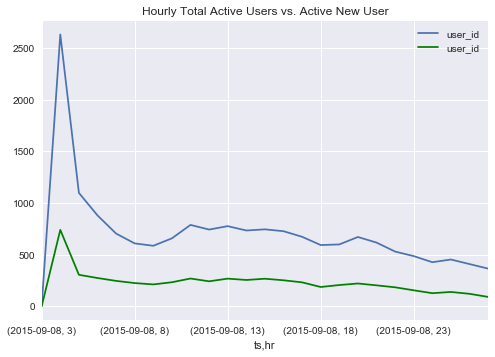

In [83]:
#plot line chart for hourly user activity in df_act
lst_act_new_user = df_regi[df_regi.is_retained.isin([1])]['user_id']
fig, ax = plt.subplots()
df_act.groupby(['ts','hr'])['user_id'].count().plot(title = 'Hourly Total Active Users vs. Active New User',
                                                    #linewidth=5.0
                                                   )
df_act[df_act.user_id.isin(list(lst_act_new_user))].groupby(['ts','hr'])\
                                    ['user_id'].count().plot(color = 'green'
                                    #,linewidth=5.0
                                    )
ax.legend(loc = 'best')
plt.show()

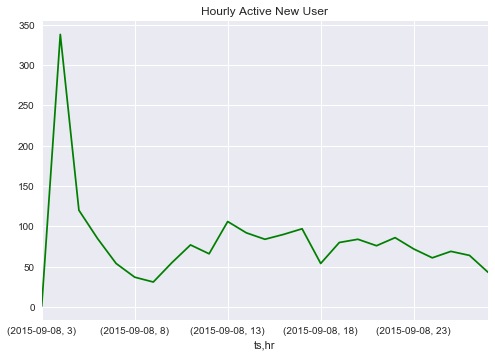

In [84]:
#plot line chart for hourl active new user activity in df_act in US
lst_act_new_user = df_regi[df_regi.is_retained.isin([1]) & df_regi['regi_geo'].isin(['US'])]['user_id']
df_act[df_act.user_id.isin(list(lst_act_new_user))].groupby(['ts','hr'])['user_id'].count().\
                        plot(color='green',title='Hourly Active New User')
plt.show()

/Applications/anaconda/envs/py27/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "ts". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<type 'datetime.date'>'
  (name, str(e)))


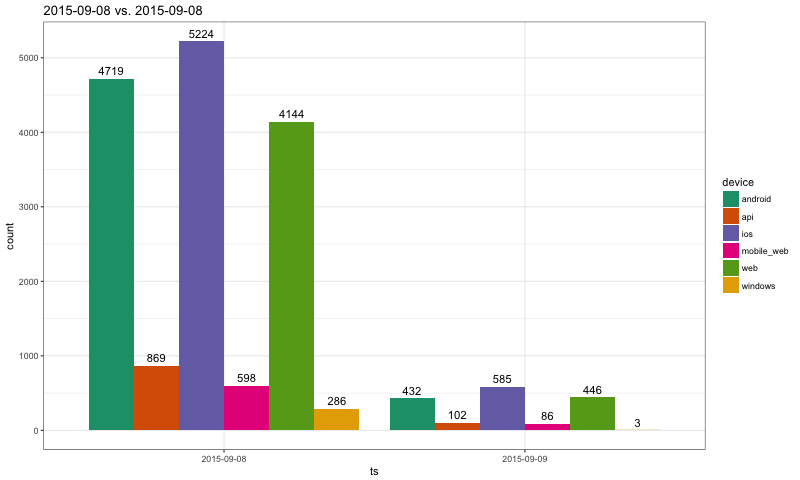

In [42]:
%%R -i df_act -w 800 -h 480 -u px
library(ggplot2)
library(dplyr)
df_act %>% 
  group_by(ts, device) %>%
  summarise(count = n_distinct(user_id)) %>%
  ggplot(aes(x=ts, y=count)) +
  geom_bar(aes(fill=device), stat='identity', position = 'dodge') +
  geom_text(
    aes(y = count, label = count, group = device),
    position = position_dodge(width = 0.9),
    vjust = -0.5, size = 4
  ) +
  #scale_y_continuous("count",limits=c(0,4.5),breaks=seq(0, 4.5, .5)) +
  theme_bw() +
  scale_fill_brewer(palette="Dark2") +
  ggtitle('2015-09-08 vs. 2015-09-08')
  

In [13]:
#quick summary of data
df_regi.describe(include='all')

,regi_ts,user_id,regi_geo,is_verified,pageviews,follows,likes,reblogs,original_posts,searches,unfollows,received_engagments,regi_device,regi_source,regi_hr,active_date,is_retained
count,14197,14197,13648,14197.000000,14197.000000,14197.000000,14197.000000,14197.000000,14197.000000,14197.000000,14197.000000,14197.000000,14197,14157,14197.000000,14197,14197.000000
unique,2,14197,145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,21,NaN,4,NaN
top,2015-09-01,186160609,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,web,none,NaN,0,NaN
freq,12002,1,4483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5662,8535,NaN,9086,NaN
mean,NaN,NaN,NaN,0.343946,6.619708,7.543425,3.901599,4.495386,0.657604,5.887159,0.395365,0.582377,NaN,NaN,12.101782,NaN,0.360006
std,NaN,NaN,NaN,0.475040,16.443838,18.539101,22.868838,26.810275,4.883617,16.667169,2.086598,9.931723,NaN,NaN,6.966651,NaN,0.480019
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,6.000000,NaN,0.000000
50%,NaN,NaN,NaN,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,13.000000,NaN,0.000000
75%,NaN,NaN,NaN,1.000000,6.000000,7.000000,1.000000,0.000000,0.000000,6.000000,0.000000,0.000000,NaN,NaN,18.000000,NaN,1.000000


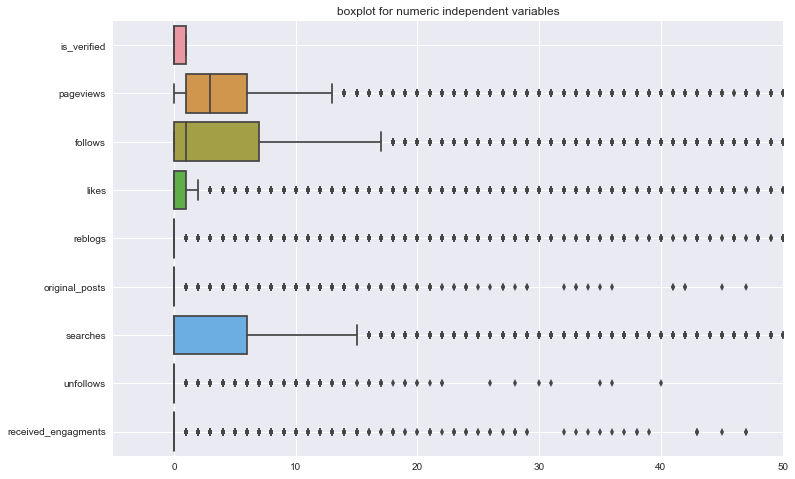

In [98]:
#boxplot for numeric independent variables

plt.figure(figsize = (12,8))
ax = sns.boxplot(data = df_regi.iloc[:,3:12], orient = "h").set_title('boxplot for numeric independent variables')
plt.grid(True)
plt.xlim((-5,50))
plt.show()

In [15]:
df_regi.groupby('regi_device')['user_id'].count()/df_regi.shape[0] * 100

regi_device
android      35.859689
api           0.929774
iphone       23.314785
web          39.881665
yahoo_hnv     0.014087
Name: user_id, dtype: float64

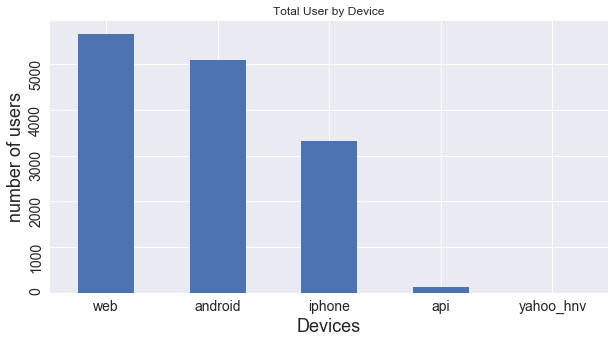

In [115]:
#bar chart for categorical variable regi_device
plt.figure(figsize = (10,5))
df_regi.groupby('regi_device')['user_id'].count().sort_values(ascending = False).plot.bar(
    title = 'Total User by Device')

plt.ylabel('number of users',fontsize = 18)
#fig.suptitle('test title', fontsize = 20)
plt.xlabel('Devices', fontsize = 18)
plt.xticks(fontsize = 14, rotation = 0)
plt.yticks(fontsize = 14, rotation = 90)
plt.show()

In [17]:
df_regi.groupby('regi_geo')['user_id'].count().sort_values(ascending = False).\
head(10)/df_regi.shape[0] * 100

regi_geo
US    31.577094
GB     5.522293
BR     5.402550
TR     4.670001
KR     3.324646
IT     3.035853
DE     2.958371
MX     2.563922
CA     2.521660
ID     2.324435
Name: user_id, dtype: float64

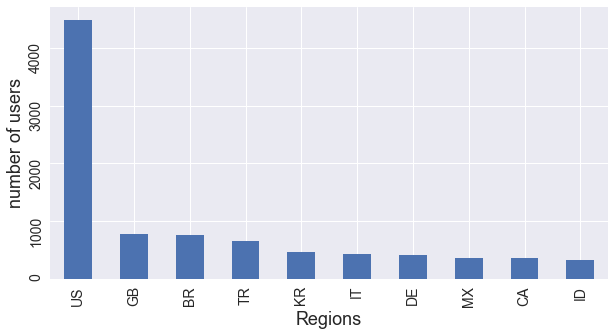

In [108]:
#bar chart for categorical variable regi_geo
plt.figure(figsize = (10,5))
df_regi.groupby('regi_geo')['user_id'].count().sort_values(ascending = False).head(10).plot.bar()
plt.ylabel('number of users',fontsize = 18)
#fig.suptitle('test title', fontsize = 20)
plt.xlabel('Regions', fontsize = 18)
plt.xticks(fontsize = 14, rotation = 90)
plt.yticks(fontsize = 14, rotation = 90)
plt.show()

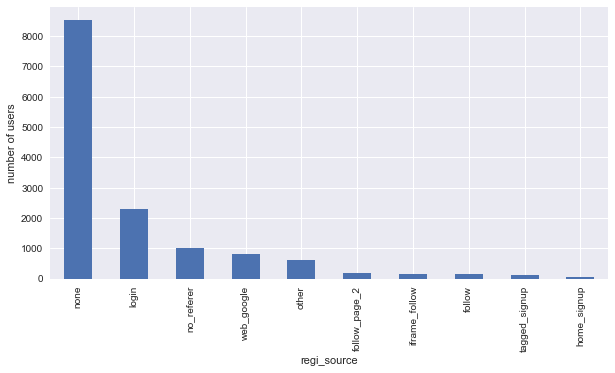

In [19]:
#bar chart for categorical variable regi_source
plt.figure(figsize = (10,5))
df_regi.groupby('regi_source')['user_id'].count().sort_values(ascending = False).head(10).plot.bar()
plt.ylabel('number of users')
plt.show()

<p><a name="Univariate"></a></p>
##### Univariate - dependent variable ('is_retained') 

In [20]:
df_regi['is_retained'].value_counts()

0    9086
1    5111
Name: is_retained, dtype: int64

<p><a name="Multivariate"></a></p>
#### Multivariate - how the dependent variable and independent variables relate. 

<p><a name="Numerical"></a></p>
Relationship with numerical variables

In [21]:
df_regi.columns

Index([u'regi_ts', u'user_id', u'regi_geo', u'is_verified', u'pageviews',
       u'follows', u'likes', u'reblogs', u'original_posts', u'searches',
       u'unfollows', u'received_engagments', u'regi_device', u'regi_source',
       u'regi_hr', u'active_date', u'is_retained'],
      dtype='object')

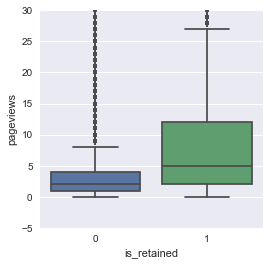

In [22]:
#box plot pageviews/actived status
var = 'pageviews'
data = pd.concat([df_regi[var],df_regi['is_retained']], axis = 1)
f, ax = plt.subplots(figsize = (4, 4))
fig = sns.boxplot(x='is_retained', y = var, data = data)
fig.axis(ymin = -5, ymax=30);
plt.show()

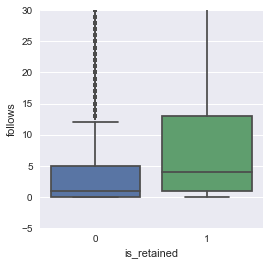

In [23]:
#box plot follows/actived status
var = 'follows'
data = pd.concat([df_regi[var],df_regi['is_retained']], axis = 1)
f, ax = plt.subplots(figsize = (4, 4))
fig = sns.boxplot(x = 'is_retained', y = var, data = data)
fig.axis(ymin = -5, ymax = 30);
plt.show()

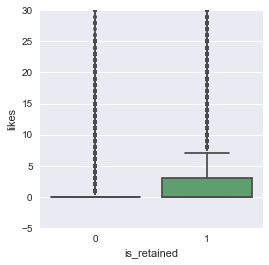

In [24]:
#scatter plot likes/actived status
var = 'likes'
data = pd.concat([df_regi[var],df_regi['is_retained']], axis = 1)
f, ax = plt.subplots(figsize = (4, 4))
fig = sns.boxplot(x = 'is_retained', y = var, data = data)
fig.axis(ymin = -5, ymax = 30);
plt.show()

<p><a name="Categorical"></a></p>
Relationship with categorical features

In [86]:
# chi square test independency registered/actived status 
#create test data
var = 'regi_device'
data = pd.concat([df_regi[var],df_regi['is_retained'].astype(str)], axis = 1)

print len(data.is_retained),len(data.regi_device)

14197 14197



	Pearson's Chi-squared test

data:  overall_device_active
X-squared = 89.351, df = 4, p-value < 2.2e-16



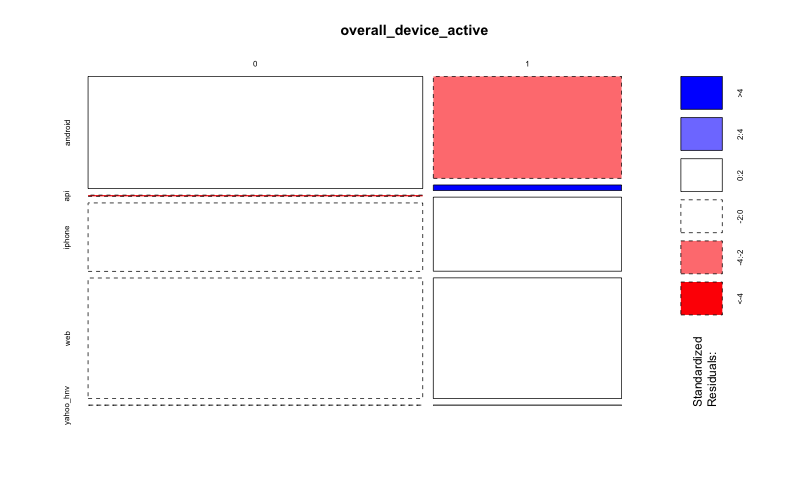

In [87]:
%%R -i data -w 800 -h 480 -u px
library(dplyr)
overall_device_active <- table(data$is_retained, data$regi_device)
mosaicplot(overall_device_active, shade = TRUE)
b <- chisq.test(overall_device_active)
b

Since both variables are categorical, we used the Chi-squared test to test whether they are independent. The result has extremely small p-values, which rejects the null hypothesis that the two variables are independent of each other. The values shows the difference between the actual observations and expected values. When difference is positive, it shows that it was likely that the test has a postive effect on the respective event. When difference is negative, it shows that it was likely that the test has a negative effect on the respective event. The color intense shows the magnitudes of residuals.

Samll amount of users registered with API and they are more likely to be active again. API data is diluting the data. 

In [27]:
#remove api records and test independency again for registered/actived status 
var = 'regi_device'
data = pd.concat([df_regi[var],df_regi['is_retained'].astype(str)], axis = 1)
data = data[data.regi_device != 'api']

print len(data.is_retained),len(data.regi_device)

14065 14065


In [28]:
set(data.regi_device.values)

{'android', 'iphone', 'web', 'yahoo_hnv'}


	Pearson's Chi-squared test

data:  overall_device_active
X-squared = 14.594, df = 3, p-value = 0.002199



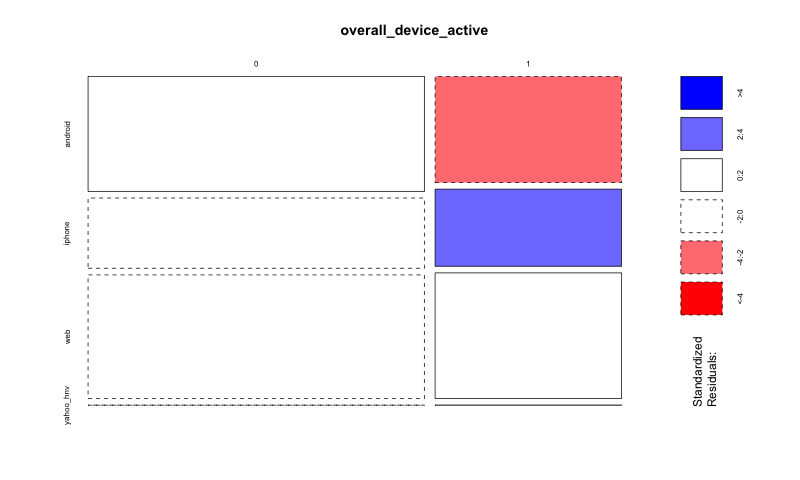

In [29]:
%%R -i data -w 800 -h 480 -u px
library(dplyr)
overall_device_active <- table(data$is_retained, data$regi_device)
mosaicplot(overall_device_active, shade = TRUE)
b <- chisq.test(overall_device_active)
b

Now the detail of how iphone and android are not indpendent / affecting user retention is unveiled. User registered with android are less likely to be active again. User registered with iphone are more likely to be active again. 

In [30]:
# chi square test independency is_verified/actived status 

#create test data
var = 'is_verified'
data = pd.concat([df_regi[var],df_regi['is_retained'].astype(str)], axis = 1)

print len(data.is_retained),len(data.is_verified)

14197 14197



	Pearson's Chi-squared test with Yates' continuity correction

data:  overall_veri_active
X-squared = 365.77, df = 1, p-value < 2.2e-16



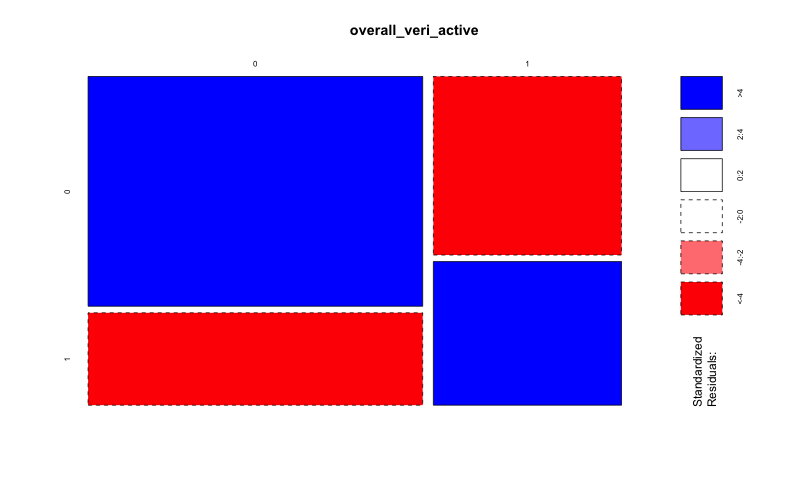

In [31]:
%%R -i data -w 800 -h 480 -u px
library(dplyr)
overall_veri_active <- table(data$is_retained, data$is_verified)
mosaicplot(overall_veri_active, shade = TRUE)
b <- chisq.test(overall_veri_active)
b

In [32]:
lst_top_geo = list(df_regi.groupby('regi_geo')['user_id'].count().sort_values(ascending = False).head(10).index)

In [33]:
#chi square test independency registered geo/actived status 

#create test data
var = 'regi_geo'

data = pd.concat([df_regi[var],df_regi['is_retained'].astype(str)], axis=1)
data = data[data.regi_geo.isin(lst_top_geo)]

print len(data.is_retained),len(data.regi_geo)

9072 9072



	Pearson's Chi-squared test

data:  overall_geo_active
X-squared = 113.45, df = 9, p-value < 2.2e-16



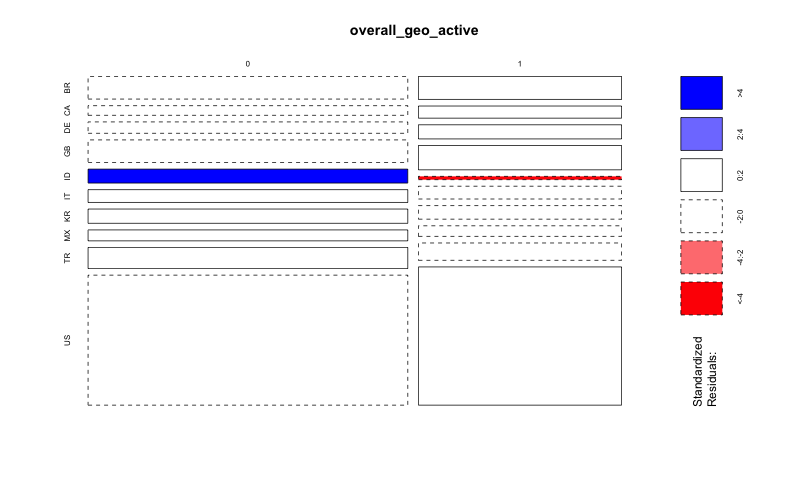

In [34]:
%%R -i data -w 800 -h 480 -u px
library(dplyr)
overall_geo_active <- table(data$is_retained, data$regi_geo)
mosaicplot(overall_geo_active, shade = TRUE)
b <- chisq.test(overall_geo_active)
b

ID- Indonesia users appear to be less likely to be active agian.

<p><a name="Multivariate2"></a></p>
#### Multivariate - relationship between two independent variables

<p><a name="Country"></a></p>
User behaviors among regions

By checking registered geo with total users/pageviews/follows, user behaviors are different among countries. ID-Indonesia ranked 10th by number of users. While not in top 10 list by total pageviews. TR-Turkey ranked 4th by number of users. While 3rd by total pageviews.

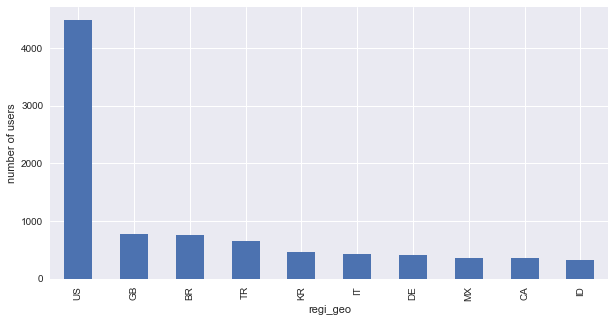

In [35]:
plt.figure(figsize = (10,5))
df_regi.groupby('regi_geo')['user_id'].count().sort_values(ascending = False).head(10).plot.bar()
plt.ylabel('number of users')
plt.show()

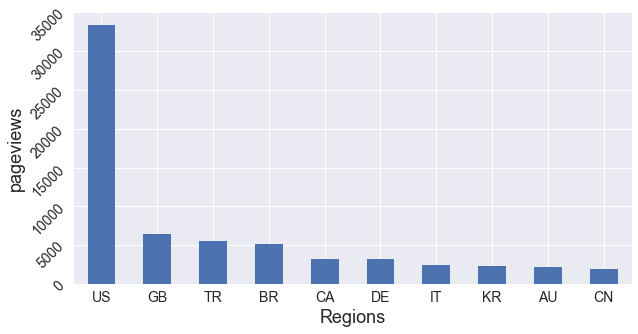

In [128]:
plt.figure(figsize = (10,5))
df_regi.groupby('regi_geo')['pageviews'].sum().sort_values(ascending = False).head(10).plot.bar()
plt.ylabel('pageviews',fontsize = 18)
#fig.suptitle('test title', fontsize = 20)
plt.xlabel('Regions', fontsize = 18)
plt.xticks(fontsize = 14, rotation = 0)
plt.yticks(fontsize = 14, rotation = 45)
plt.show()

In [125]:
df_regi.groupby('regi_geo')['pageviews'].sum().sort_values(ascending = False).\
head(10)/sum(df_regi.pageviews) *100

regi_geo
US    35.527772
GB     6.868483
TR     5.941690
BR     5.463928
CA     3.376250
DE     3.369866
IT     2.587785
KR     2.485635
AU     2.347308
CN     2.029155
Name: pageviews, dtype: float64

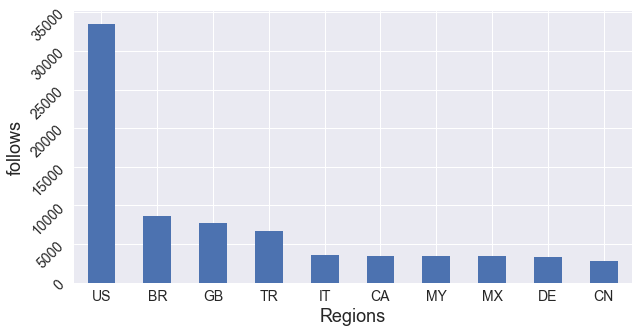

In [127]:
plt.figure(figsize = (10,5))
df_regi.groupby('regi_geo')['follows'].sum().sort_values(ascending = False).head(10).plot.bar()
plt.ylabel('follows',fontsize = 18)
#fig.suptitle('test title', fontsize = 20)
plt.xlabel('Regions', fontsize = 18)
plt.xticks(fontsize = 14, rotation = 0)
plt.yticks(fontsize = 14, rotation = 45)
plt.show()

In [126]:
df_regi.groupby('regi_geo')['follows'].sum().sort_values(ascending = False).\
head(10)/sum(df_regi.follows) *100

regi_geo
US    31.262256
BR     8.059275
GB     7.184343
TR     6.218836
IT     3.306441
CA     3.230807
MY     3.199993
MX     3.176649
DE     3.067399
CN     2.675220
Name: follows, dtype: float64

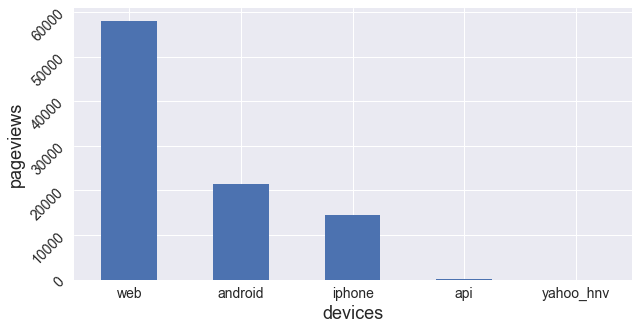

In [159]:
plt.figure(figsize = (10,5))
df_regi.groupby('regi_device')['pageviews'].sum().sort_values(ascending = False).head(10).plot.bar()
plt.ylabel('pageviews',fontsize = 18)
#fig.suptitle('test title', fontsize = 20)
plt.xlabel('devices', fontsize = 18)
plt.xticks(fontsize = 14, rotation = 0)
plt.yticks(fontsize = 14, rotation = 45)
plt.show()

In [164]:
df_regi.groupby('regi_device')['pageviews'].sum().sort_values(ascending = False).\
head(10)/sum(df_regi.follows) *100

regi_device
web          54.213121
android      19.977777
iphone       13.494687
api           0.066297
yahoo_hnv     0.002801
Name: pageviews, dtype: float64

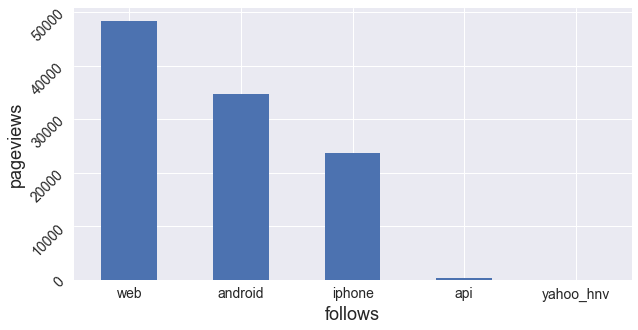

In [162]:
plt.figure(figsize = (10,5))
df_regi.groupby('regi_device')['follows'].sum().sort_values(ascending = False).head(10).plot.bar()
plt.ylabel('pageviews',fontsize = 18)
#fig.suptitle('test title', fontsize = 20)
plt.xlabel('follows', fontsize = 18)
plt.xticks(fontsize = 14, rotation = 0)
plt.yticks(fontsize = 14, rotation = 45)
plt.show()

In [163]:
df_regi.groupby('regi_device')['follows'].sum().sort_values(ascending = False).\
head(10)/sum(df_regi.follows) *100

regi_device
web          45.146320
android      32.384634
iphone       22.176779
api           0.292267
yahoo_hnv     0.000000
Name: follows, dtype: float64

<p><a name="Corr"></a></p>
Correlation Matrix

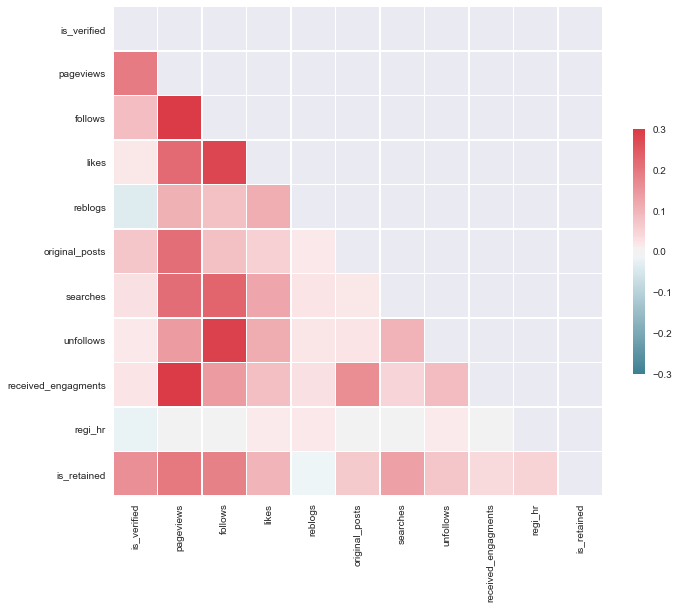

In [38]:
# Compute the correlation matrix
corr = df_regi.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

plt.show()

Reglogs appear to be negtively correlated to is_retained while is_verified,pageviews,follows and searches appear to be positive correlated to is_retained user active status.

<p><a name="Scatter"></a></p>
Scatter plot

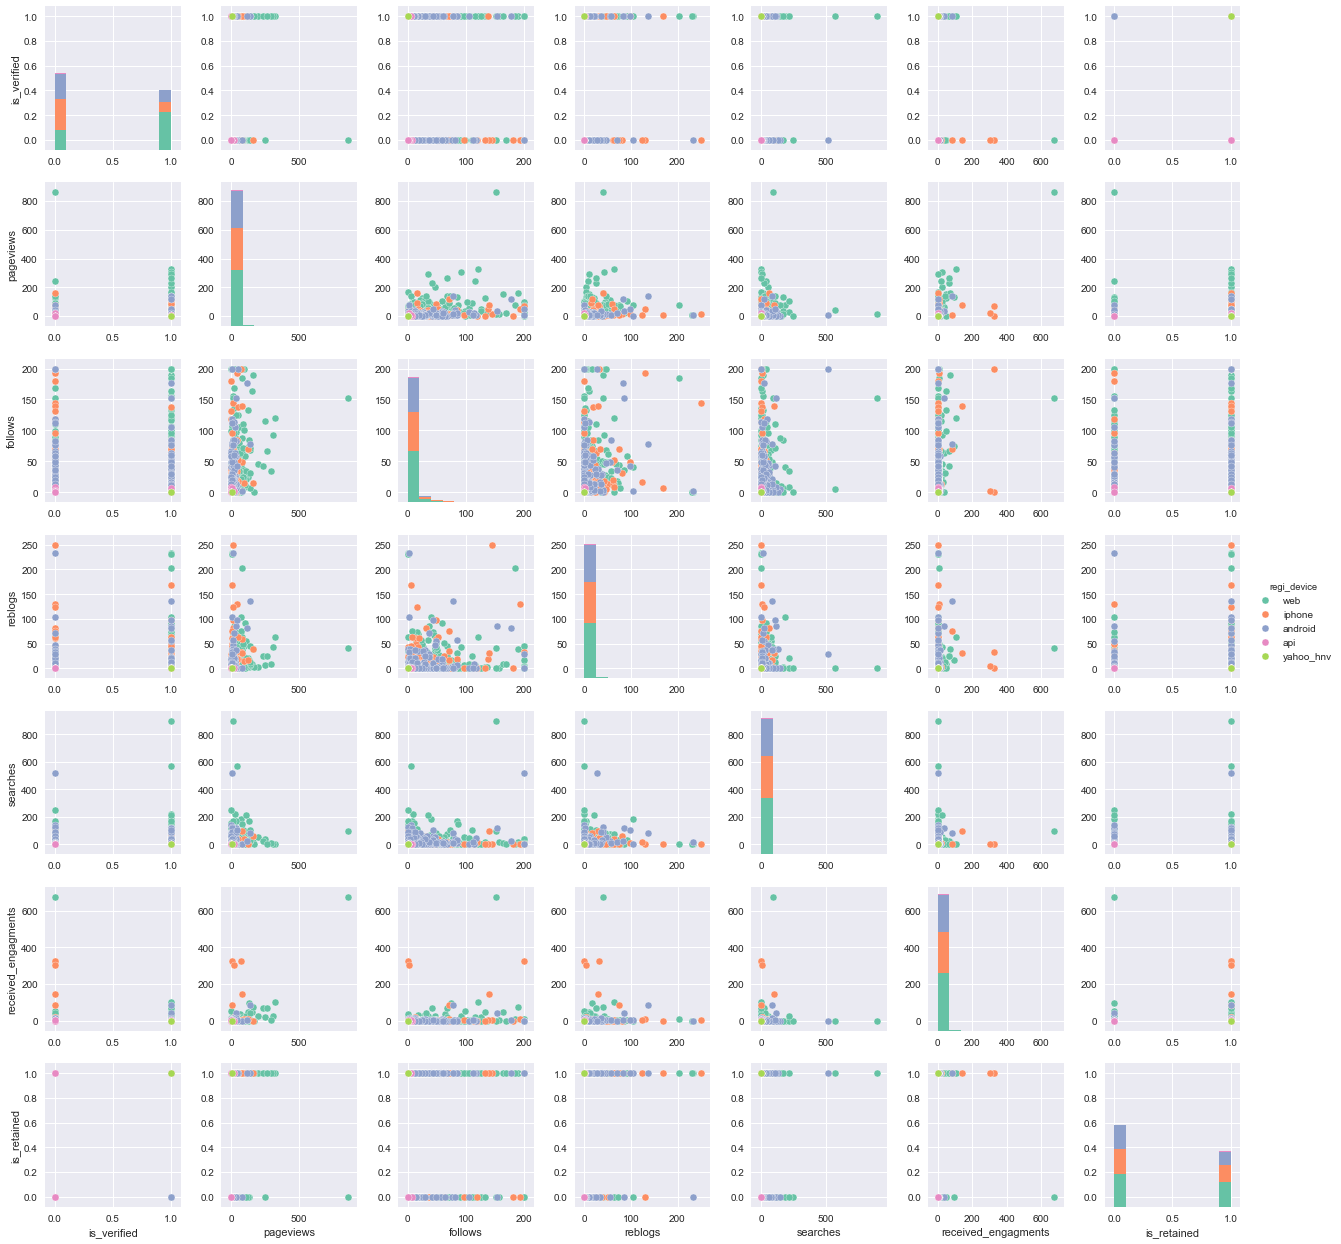

In [39]:
#scatterplot for relationship of 2 numeric variables for ONLY US
sns.set()
#cols = list(df_regi.select_dtypes(include=[np.number]).columns.values)[1:]+['regi_device']
cols = [
 'is_verified',
 'pageviews',
 'follows',
 'reblogs',
 'searches',
 'received_engagments',
 'is_retained'] +['regi_device']
#g = sns.PairGrid(iris, hue = 'species', palette='Set2',\
#           hue_kws={'cmap':['Greens','Oranges','Blues']})

sns.pairplot(df_regi[cols][df_regi.regi_geo == 'US'], hue = 'regi_device', palette = 'Set2',size = 2.5)
plt.show()

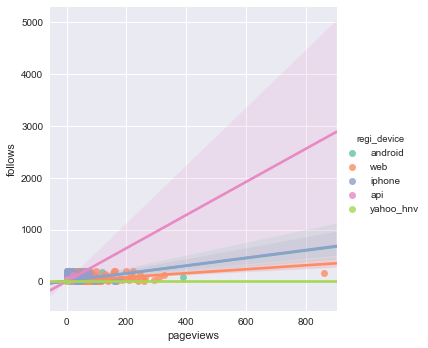

In [181]:
sns.lmplot("pageviews", "follows", df_regi, hue="regi_device", palette="Set2")
plt.show()

<p><a name="Retention Rate"></a></p>
### 2. Retention Rate and Important Factors
What percentage of registered users were retained? What are the most important factors that appear to be affecting user retention? What are the implications of those factors affecting retention? What actionable insights can be derived from this exercise?

<p><a name="Rate"></a></p>
#### Caculate the Retention Rates

In [43]:
# retention rates for user who started at day 1 and day 2
print df_regi.groupby('regi_ts')['is_retained'].sum() * 1.0 / df_regi.groupby('regi_ts')['is_retained'].count()* 100

# retention rate for user who either started at day 1 or day 2
print ''
print 'Overall Retention Rate: ' 
print  round(sum(df_regi['is_retained'])*1.0 / len(df_regi['is_retained']) * 100,2)

regi_ts
2015-09-01    35.869022
2015-09-02    36.719818
Name: is_retained, dtype: float64

Overall Retention Rate: 
36.0


<p><a name="Factors"></a></p>
<p><a name="Variance"></a></p>
#### Feature Selection : We will use some basic methods from a mathematics perspective:
1. Removing features with low variance
2. Univariate feature selection

In [44]:
df_regi.columns

Index([u'regi_ts', u'user_id', u'regi_geo', u'is_verified', u'pageviews',
       u'follows', u'likes', u'reblogs', u'original_posts', u'searches',
       u'unfollows', u'received_engagments', u'regi_device', u'regi_source',
       u'regi_hr', u'active_date', u'is_retained'],
      dtype='object')

In [45]:
#create df for only nemeric columns for the variance check
numeric_cols = df_regi[['is_verified', 'pageviews',
       'follows', 'likes', 'reblogs', 'original_posts', 'searches',
       'unfollows', 'received_engagments']]

Featuer is_verified has lowesting variance and be removed for following analysis. 

Also, it will be treated as a categorical factor via earlier analysis.

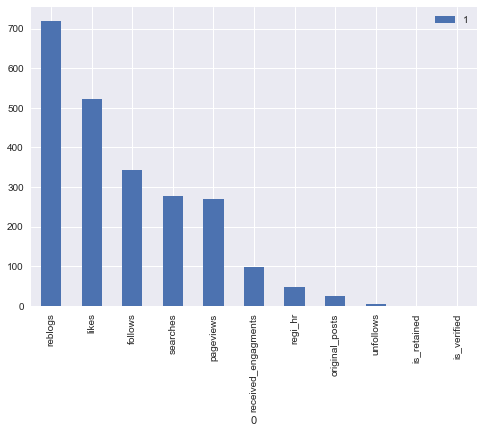

In [46]:
#features with high variance
pd.DataFrame(zip(np.var(df_regi, 0).index,np.var(df_regi, 0))).sort_values(1,ascending = False).plot.bar(x=0,y=1)
plt.show()

In [47]:
#The variances of the features are:
import pprint
print('Shape: (%d, %d)' %df_regi.shape)
print('Variation:')
pprint.pprint(dict(zip(np.var(df_regi, 0).index,np.var(df_regi, 0))))

Shape: (14197, 17)
Variation:
{'follows': 343.67404935498263,
 'is_retained': 0.2304015777664129,
 'is_verified': 0.22564711914166102,
 'likes': 522.94692778074977,
 'original_posts': 23.848039140556107,
 'pageviews': 270.38077097925697,
 'reblogs': 718.74022313214505,
 'received_engagments': 98.63216951572376,
 'regi_hr': 48.530811080770597,
 'searches': 277.77496859424622,
 'unfollows': 4.3535828013905968}


<p><a name="Test"></a></p>
#### Univariate feature selection based on average scores of tests  (feature stand alone significance by comparing to label)

In [48]:
df_regi.columns

Index([u'regi_ts', u'user_id', u'regi_geo', u'is_verified', u'pageviews',
       u'follows', u'likes', u'reblogs', u'original_posts', u'searches',
       u'unfollows', u'received_engagments', u'regi_device', u'regi_source',
       u'regi_hr', u'active_date', u'is_retained'],
      dtype='object')

In [49]:
x = df_regi.iloc[:,4:12]
y = df_regi.iloc[:,15:16]
list(x.columns)

['pageviews',
 'follows',
 'likes',
 'reblogs',
 'original_posts',
 'searches',
 'unfollows',
 'received_engagments']

In [50]:
#create 4 bins (0%-25%,25%-50%,50%-75%,75%-100%) for all features if allows
qtile_idx = [0.25,0.5,.75,1.0]
qtile = x.quantile(qtile_idx, axis=0)
print qtile

th1 = 0
th2 = 0
th3 = 0

x_map = df_regi.copy()

def mapper(x):
    if x <= th1:
        return 0
    elif x > th1 and x <= th2:
        return 1
    elif x > th2 and x <= th3:
        return 2
    else:
        return 3

for var in list(x.columns):
    threshold = qtile[var]
    th1 = threshold.iloc[0]
    th2 = threshold.iloc[1]
    th3 = threshold.iloc[2]
    x_map[var] = x_map[var].map(mapper)
    print x_map[var].value_counts()

      pageviews  follows   likes  reblogs  original_posts  searches  \
0.25        1.0      0.0     0.0      0.0             0.0       0.0   
0.50        3.0      1.0     0.0      0.0             0.0       0.0   
0.75        6.0      7.0     1.0      0.0             0.0       6.0   
1.00      860.0    200.0  1000.0    263.0           250.0     896.0   

      unfollows  received_engagments  
0.25        0.0                  0.0  
0.50        0.0                  0.0  
0.75        0.0                  0.0  
1.00      120.0                674.0  
0    4978
1    3583
3    3435
2    2201
Name: pageviews, dtype: int64
0    4975
2    3628
3    3392
1    2202
Name: follows, dtype: int64
0    10184
3     2874
2     1139
Name: likes, dtype: int64
0    11901
3     2296
Name: reblogs, dtype: int64
0    11593
3     2604
Name: original_posts, dtype: int64
0    7146
2    3774
3    3277
Name: searches, dtype: int64
0    11922
3     2275
Name: unfollows, dtype: int64
0    12916
3     1281
Name: receiv

In [51]:
x1 = x_map.iloc[:,4:12]
y1 = x_map.iloc[:,15:16]
list(x.columns)

['pageviews',
 'follows',
 'likes',
 'reblogs',
 'original_posts',
 'searches',
 'unfollows',
 'received_engagments']

In [52]:
def norm(x):
    return (x-min(x))/(max(x)-min(x))

In [88]:
##Create tests##
#######test1 - chi2#######
selector = fs.SelectKBest(fs.chi2, k=5)
selector.fit(x1, y1)
# Get idxs of columns to keep
idxs_selected = selector.get_support(indices = True)
# Create new dataframe with only desired columns, or overwrite existing
x_new = x.columns[idxs_selected]

scores = norm(selector.scores_)
print x_new
print scores

######test2 - f_classif#######
# Create and fit selector
selector = fs.SelectKBest(fs.f_classif, k=5)
selector.fit(x, y)
# Get idxs of columns to keep
idxs_selected = selector.get_support(indices = True)
# Create new dataframe with only desired columns, or overwrite existing
x_new = x.columns[idxs_selected]
    
scores += norm(selector.scores_)
print x_new
print norm(selector.scores_)


######test3 - mutual_info_classif#######
def my_score(X_, y_):
    return fs.mutual_info_classif(X_, y_, random_state = 1000)

selector = fs.SelectKBest(my_score, k = 5)
selector.fit(x,y)
# Get idxs of columns to keep
idxs_selected = selector.get_support(indices = True)
# Create new dataframe with only desired columns, or overwrite existing
x_new = x.columns[idxs_selected]
    
scores += norm(selector.scores_)
print x_new
print norm(selector.scores_)

Index([u'pageviews', u'follows', u'likes', u'reblogs', u'received_engagments'], dtype='object')
[ 1.          0.48884661  0.65097702  0.93039508  0.          0.29532668
  0.30697945  0.55777968]
Index([u'pageviews', u'follows', u'likes', u'searches', u'unfollows'], dtype='object')
[ 1.          0.81933113  0.22666844  0.          0.09396421  0.41021408
  0.11513975  0.0277004 ]
Index([u'pageviews', u'follows', u'reblogs', u'searches',
       u'received_engagments'],
      dtype='object')
[ 1.          0.64174489  0.25206347  0.41230122  0.          0.41374178
  0.08255261  0.26121547]


In [54]:
#Rank of importance features based on average SelectKBest scores from 
#Chi square independent test, ANOVA F-value test and KNN test
pd.DataFrame(zip(x.columns,scores/3),columns = ['features','scores']).sort_values(by = ['scores'],ascending = False)

,features,scores
0,pageviews,1.000000
1,follows,0.649974
3,reblogs,0.447565
2,likes,0.376570
5,searches,0.373094
7,received_engagments,0.282232
6,unfollows,0.168224
4,original_posts,0.031321


<p><a name="Segment"></a></p>
#### Segment Cohorts based on Most Important Behaviors 

In [55]:
top_features = pd.DataFrame(zip(x.columns,scores/3),
                          columns = ['features','scores']).sort_values(by = ['scores'],
                          ascending = False)['features'].head(5)

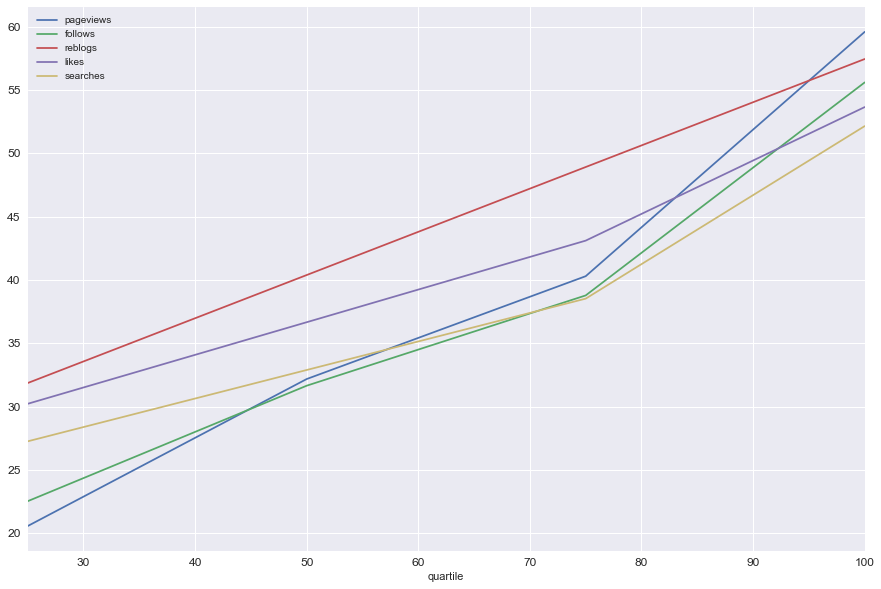

In [56]:
#plot the retention rates for all behavior cohorts within dataset for each top feature 
fig, ax = plt.subplots()
labels = []
for var in list(top_features):
    i = 0
    retention_per_qtile = pd.DataFrame(x_map.groupby([var])['is_retained'].sum()*100/x_map[var].\
                                       value_counts(), 
                                       columns=['retention'])
    max_per_qtile = pd.DataFrame(zip(qtile[var],
                                     #(pd.Series(qtile_idx))
                                     #['0%-25%','25%-50%','50%-75%','75%-100%']
                                     [25,50,75,100]
                                    ),
                                 index = [0, 1, 2, 3], columns = ['max','quartile'])

    retention_per_qtile = max_per_qtile.join(retention_per_qtile, how = 'inner')
    retention_per_qtile.plot(kind = 'line',  figsize = (15, 10), legend = True, 
              fontsize = 12,x = 'quartile',y = 'retention',ax = ax)
    labels.append(var)
    lines, _ = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc = 'best')
    #print retention_per_qtile
    
plt.show()

#### Actionable Insights : Discover Which Behaviors Drive Retention Rate

In [57]:
print '75% percentile of top 3 features: '
print 'pageviews :'
print df_regi.pageviews.quantile(0.75)
print 'follows :'
print df_regi.follows.quantile(0.75)

#print df_regi.reblogs.quantile(0.75)
#0

print 'reblogs: '
print df_regi.reblogs.quantile(0.85)

75% percentile of top 3 features: 
pageviews :
6.0
follows :
7.0
reblogs: 
1.0


<p><a name="Presentation"></a></p>
#### Slide for Presensation

#### Click the Link
https://docs.google.com/presentation/d/1WYa09LWlMSJTeOjViAoPTxvLS31lvyi6ubhFkq-5WGI/edit?usp=sharing